In [1]:
#from dataset import Dataset
import time
from keras.datasets import cifar10
import numpy as np
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import seaborn as sns
import random
import sys

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data
from torch.nn.modules.loss import CrossEntropyLoss

import torchvision.datasets as datasets

import sklearn
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.metrics import hinge_loss

import copy
from copy import deepcopy
import random
import time

import json
import os
from PIL import Image

import tqdm


import ezkl, onnx

In [2]:
# Class Dictionary for CIFAR10
classDict = {'plane': 0, 'car': 1, 'bird': 2, 'cat': 3, 'deer': 4,
             'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}

binaryClasses = {0:'Machine', 1:'Animal'} # Machine , Animal

data_mean = (0.4914, 0.4822, 0.4465)
data_std = (0.2470, 0.2435, 0.2616)

### Data Prepartion

In [3]:
from torch.nn.modules.transformer import TransformerDecoderLayer
# Overwrite getitem method to obtain the index of the images when iterating through the images

from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader


class CIFAR10(Dataset):
    def __init__(self, train, transform):
        self.cifar10 = torchvision.datasets.CIFAR10(
                        root='./data', train=train, download=True, transform=transform)
        self.targets = self.cifar10.targets
        self.classes = self.cifar10.classes
        self.data = self.cifar10.data


    # Overloaded the getitem method to return index as well
    def __getitem__(self, index):
        data, target = self.cifar10[index]
        return data, target, index

    # Method to get all images' indices from a certain class without iterating through the loader
    def get_index(self, target_label):
      index_list = []
      for index, label in enumerate(self.targets):
        if label == target_label:
          index_list.append(index)
      return index_list

    def __len__(self):
        return len(self.cifar10)

    def remove(self, remove_list):
      mask = np.ones(len(self.cifar10), dtype=bool)
      mask[remove_list] = False
      data = self.data[mask]

# Data Prep.
inv_normalize = transforms.Normalize(
   mean= [-m/s for m, s in zip(data_mean, data_std)],
   std= [1/s for s in data_std]
)

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(data_mean, data_std),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(data_mean, data_std),
])


In [5]:
trainset = CIFAR10(train=True, transform=transform_train)
testset = CIFAR10(train=False, transform=transform_test)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


## NN Model

In [6]:
class ResNet(torchvision.models.ResNet):
    """ResNet generalization for CIFAR-like thingies.

    This is a minor modification of
    https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py,
    adding additional options.
    """

    def __init__(self, block, layers, num_classes=2, zero_init_residual=False,
                 groups=1, base_width=64, replace_stride_with_dilation=[False, False, False, False],
                 norm_layer=torch.nn.BatchNorm2d, strides=[1, 2, 2, 2], initial_conv=[3, 1, 1]):
        """Initialize as usual. Layers and strides are scriptable."""
        super(torchvision.models.ResNet, self).__init__()  # torch.nn.Module
        self._norm_layer = norm_layer

        self.dilation = 1
        if len(replace_stride_with_dilation) != 4:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 4-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups

        self.inplanes = base_width
        self.base_width = 64  # Do this to circumvent BasicBlock errors. The value is not actually used.
        self.conv1 = torch.nn.Conv2d(3, self.inplanes, kernel_size=initial_conv[0],
                                     stride=initial_conv[1], padding=initial_conv[2], bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = torch.nn.ReLU(inplace=True)

        layer_list = []
        width = self.inplanes
        for idx, layer in enumerate(layers):
            layer_list.append(self._make_layer(block, width, layer, stride=strides[idx], dilate=replace_stride_with_dilation[idx]))
            width *= 2
        self.layers = torch.nn.Sequential(*layer_list)

        self.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))
        self.fc = torch.nn.Linear(width // 2 * block.expansion, num_classes)
        #self.predict = nn.Sigmoid()

        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (torch.nn.BatchNorm2d, torch.nn.GroupNorm)):
                torch.nn.init.constant_(m.weight, 1)
                torch.nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the arch by 0.2~0.3% according to https://arxiv.org/abs/1706.02677



    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layers(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x) # Sigmoid
        #x = self.predict(x)
        return x

initial_conv = [3, 1, 1]
NN_model = ResNet(torchvision.models.resnet.BasicBlock, [2, 2, 2, 2], num_classes=10, base_width=64, initial_conv=initial_conv)

In [7]:
if torch.backends.mps.is_available():
    device = torch.device('mps')
    x = torch.ones(1, device=device)
    print(x)
else:
    print("Running on a CPU...Uhh, are you sure you want to do this?")

tensor([1.], device='mps:0')


In [8]:
# Setting up training params
epochs = 21
eta = 0.01
optimizer = torch.optim.SGD(params = NN_model.parameters(), lr = eta, weight_decay = 5e-4, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

loss_fun = nn.CrossEntropyLoss()

NN_model.to(device)
NN_model.train()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layers): Sequential(
    (0): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3,

In [9]:
# Used for NN
DATASET = 'CIFAR10'      # Choose between 'CIFAR2', 'CIFAR10'
MODEL = 'RESNET18'       # Choose between 'RESNET18', 'VGG11'
AUGMENTS = True          # Use Data Augmentation
SAVEMODEL = False         # Save Clean Model
# LOADMODEL = False        # Load Clean Model

# Save or Load Clean Model

import os
PATH = "./crypto_hackathon/model"
os.makedirs(PATH, exist_ok = True)
PATH += "/resnet_cifar.ptr"

In [10]:
def evaluate_model(loader, model, valid_losses = [], correct = 0, total = 0):
    model.eval()

    # Evaluate Model
    for inputs, labels, index in loader:
        inputs, labels = inputs.to(device), labels.to(device)


        with torch.no_grad():
            output = model(inputs)
            if DATASET == 'CIFAR2':
                labels = labels.to(torch.float32)
                output = output.flatten()

        # negative labels: when using hinge embedding loss only
        flipped_labels = labels # * -1
        loss = loss_fun(output, flipped_labels)   # Calculate loss

        valid_loss = loss_fun(output, labels)
        valid_losses.append(valid_loss.item())

        #predictions = torch.argmax(output, dim=1)
        if DATASET == 'CIFAR2':
            predictions = torch.where(output < 0, 0, 1)
        else:
            predictions = torch.argmax(output.data, dim=1)
        total += labels.size(0)
        correct += (predictions == labels).sum().item()

    return valid_losses, correct, total


In [11]:
# if local model is not supported
NN_model.load_state_dict(torch.load("./crypto_hackathon/cuda_resnet_cifar.ptr", map_location='cpu'))
NN_model.to('mps')
#torch.save(NN_model.state_dict, PATH)

valid_losses, correct, total = evaluate_model(testloader, NN_model)
print("Valid loss: {}, Accuracy: {}".format(np.mean(valid_losses), correct / total))

Valid loss: 0.6206142967939376, Accuracy: 0.8369


## SVM Model


### Data processing

In [12]:
import numpy as np
import torch

def rgb_to_gray(images):
    # Assuming images are (C, H, W) and C=3 for RGB
    return np.dot(images.numpy().transpose((1, 2, 0)), [0.2989, 0.5870, 0.1140])

def process_dataset(dataset, label_map=[2, 3, 4, 5, 6, 7]):
    x_processed = []
    y_processed = []
    img_norms = []
    for index in range(len(dataset)):
        # Retrieve data and target from dataset
        data, target, _ = dataset[index]

        # Convert image to grayscale
        img_grayscale = rgb_to_gray(data)

        # Normalize grayscale image
        norm = np.linalg.norm(img_grayscale, ord=2)
        img_normalized = img_grayscale / norm

        # Store the processed image and label
        x_processed.append(img_normalized.flatten())
        img_norms.append(norm)
        y_processed.append(target in label_map)

    # Convert lists to numpy arrays
    x_processed = np.array(x_processed)
    y_processed = np.array(y_processed, dtype=np.float32)
    img_norms = np.array(img_norms)

    return x_processed, y_processed, img_norms

# Process trainset and testset
x_train, y_train, norms_train = process_dataset(trainset)
x_test, y_test, norms_test = process_dataset(testset)


### Fit

In [13]:
start_time = time.time()

#model_SVC = SVC(kernel = 'linear', max_iter=100, probability=True)
SVC_model = LinearSVC(loss='hinge', max_iter=30000)
#fit
SVC_model.fit(x_train, y_train)

print("Elapsed[s] : ", time.time() - start_time)
print("Train :", SVC_model.score(x_train, y_train))
print("Test :", SVC_model.score(x_test, y_test))

/opt/homebrew/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Elapsed[s] :  6.043394088745117
Train : 0.72116
Test : 0.7106


## Prepare Target Class/Loader

In [14]:
import matplotlib.pyplot as plt

def compare_imgages(img1, img2, size, inv_normalize=None):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # If an inverse normalization function is provided, apply it
    if inv_normalize:
        img_to_show = inv_normalize(img1.cpu()).permute(1, 2, 0)
    else:
        img_to_show = img1.numpy()

    # Show original image
    axs[0].imshow(img_to_show)  # Transpose back to HxWxC format
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    # Show normalized grayscale image
    axs[1].imshow(img2.reshape(size,size,1), cmap='gray')
    axs[1].set_title('Grayscale Normalized Image')
    axs[1].axis('off')

    plt.show()

def show_image(dataset, norms, ind=0, inv_normalize=None):
    # Assuming 'ind' is a valid index for the dataset
    # Retrieve data, target, and the index from the dataset
    img, target, _ = dataset[ind]

    # Convert PyTorch tensor to numpy array if necessary
    img_np = img.numpy()

    # Convert RGB to grayscale
    img_grayscale = np.dot(img_np.transpose((1, 2, 0)), [0.2989, 0.5870, 0.1140])

    # Normalize grayscale image using the norm provided
    img_normalized = img_grayscale / norms[ind]

    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # If an inverse normalization function is provided, apply it
    if inv_normalize:
        img_to_show = inv_normalize(img).permute(1, 2, 0)
    else:
        img_to_show = img_np

    # Show original image
    axs[0].imshow(img_to_show)  # Transpose back to HxWxC format
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    # Show normalized grayscale image
    axs[1].imshow(img_normalized, cmap='gray')
    axs[1].set_title('Grayscale Normalized Image')
    axs[1].axis('off')

    plt.show()

In [15]:
# classes = [2,3,5] # bird, cat, dog
from torch.utils.data import DataLoader, Subset
def gen_targetloader(dataset, target_class, num_samples = 100):
    target_index = dataset.get_index(target_class)

    if len(target_index) > num_samples:
        target_index = random.sample(target_index, num_samples)

    targetset = data.Subset(dataset, target_index)
    targetloader = torch.utils.data.DataLoader(targetset)

    return targetloader, target_index

def gen_random_subset_dataloader(dataset, num_samples = 100):
    indices = random.sample(range(len(dataset)), num_samples)
    random_subset = Subset(dataset, indices)

    return DataLoader(random_subset), indices

### Examples

In [16]:
bird_targetloader, bird_indices = gen_targetloader(testset, target_class = 2)

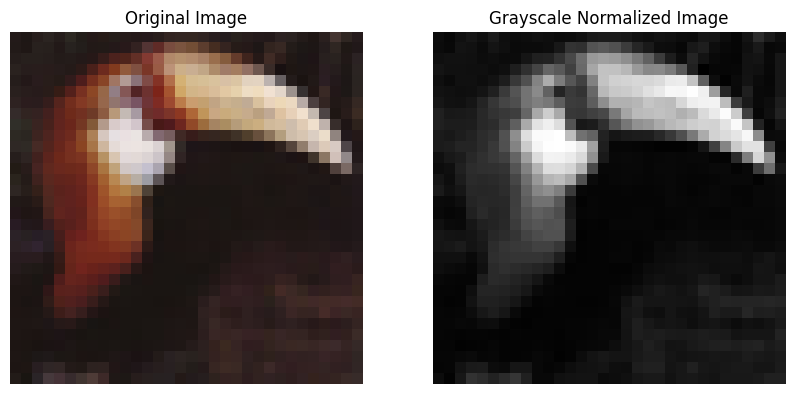

In [17]:
show_image(testset, norms_test, bird_indices[3], inv_normalize)

## Generate ZKML for NN_model and SVC_model

In [18]:
# here we create and (potentially train a model)

# make sure you have the dependencies required here already installed
import json
#import numpy as np
from sklearn.svm import SVC
import sk2torch
#import torch
import ezkl
import os

import warnings
warnings.filterwarnings('ignore')

### Examples

In [19]:
#a,b,c = testset[0]
imgs, indices, labels = [],[],[]
for input, label, index in bird_targetloader:
    input, label = input.to(device), label.to(device)
    imgs.append(input)
    indices.append(index)
    labels.append(label)

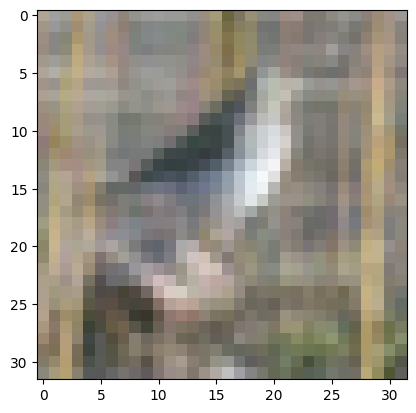

In [20]:
plt.imshow(inv_normalize(imgs[0][0].cpu()).permute(1,2,0))

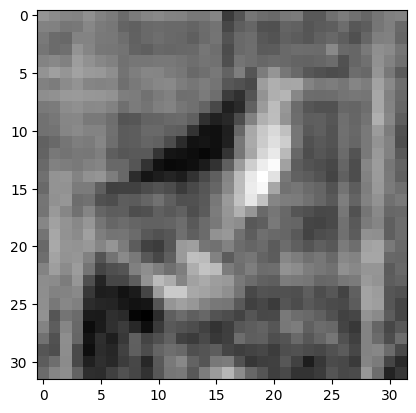

In [21]:
plt.imshow(x_test[indices[0]].reshape(32,32,1),cmap='gray')

### Helper Functions

In [22]:
async def async_function(data_path, model_path, settings_path, resource_string):
    res = await ezkl.calibrate_settings(data_path, model_path, settings_path, resource_string)
    assert res == True

In [23]:
folder = "./tmp/"

# Create the directory 'tmp' in the current working directory
try:
    os.makedirs(folder, exist_ok=True)
    print(f"Directory '{folder}' created successfully")
except OSError as error:
    print(f"Directory '{folder}' cannot be created. Error: {error}")

Directory './tmp/' created successfully


In [24]:
#pk_path = os.path.join('./tmp/test.pk')
#vk_path = os.path.join('./tmp/test.vk')
#proof_path = os.path.join('./tmp/proof.json')

def gen_witness_NN(model, img):
    model_path = os.path.join(folder, 'network.onnx')
    compiled_model_path = os.path.join(folder, 'network.compiled')
    settings_path = os.path.join(folder, 'settings.json') 
    witness_path = os.path.join(folder, 'witness.json')
    data_path = os.path.join(folder, 'input.json')
    srs_path = os.path.join(folder, 'kzg.srs')

    model = model.cpu()
    model.eval()
    x = img.cpu()

    # Export the model
    torch.onnx.export(model,                   # model being run
                    x,                         # model input (or a tuple for multiple inputs)
                    model_path,                # where to save the model (can be a file or file-like object)
                    export_params=True,        # store the trained parameter weights inside the model file
                    opset_version=10,          # the ONNX version to export the model to
                    do_constant_folding=True,  # whether to execute constant folding for optimization
                    input_names = ['input'],   # the model's input names
                    output_names = ['output'], # the model's output names
                    dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                    'output' : {0 : 'batch_size'}})

    data_array = ((x).detach().numpy()).reshape([-1]).tolist()

    data = dict(input_data = [data_array])

    # Serialize data into file:
    json.dump(data, open(data_path, 'w'))

    !RUST_LOG=trace
    # TODO: Dictionary outputs
    res = ezkl.gen_settings(model_path, settings_path)
    assert res == True

    res = async_function(data_path, model_path, settings_path, "resource")
    #res = await ezkl.calibrate_settings(data_path, model_path, settings_path, resource_string)
    #assert res == True

    res = ezkl.compile_circuit(model_path, compiled_model_path, settings_path)
    assert res == True

    # srs path
    res = ezkl.get_srs(srs_path, settings_path)

    # now generate the witness file
    res = ezkl.gen_witness(data_path, compiled_model_path, witness_path)
    assert os.path.isfile(witness_path)

    with open(witness_path, "r") as f:
        wit = json.load(f)

    with open(settings_path, "r") as f:
        setting = json.load(f)

    prediction_array = []
    for value in wit["outputs"]:
        for field_element in value:
            prediction_array.append(ezkl.vecu64_to_float(field_element, setting['model_output_scales'][0]))
    return torch.argmax(torch.Tensor([prediction_array]), dim=1)
    #print ('Prediction:', torch.argmax(torch.Tensor([prediction_array]), dim=1) == label.cpu())

In [25]:
def gen_witness_SVC(model, grayscale_img):
    model_path = os.path.join(folder, 'network.onnx')
    compiled_model_path = os.path.join(folder, 'network.compiled')
    settings_path = os.path.join(folder, 'settings.json') 
    witness_path = os.path.join(folder, 'witness.json')
    data_path = os.path.join(folder, 'input.json')
    srs_path = os.path.join(folder, 'kzg.srs')

    grayscale_img = grayscale_img.reshape(1,-1)
    model = sk2torch.wrap(model)
    x = torch.from_numpy(grayscale_img)
    torch_out = model.predict(x)

    torch.onnx.export(model,               # model being run
                    # model input (or a tuple for multiple inputs)
                    x,
                    # where to save the model (can be a file or file-like object)
                    model_path,
                    export_params=True,        # store the trained parameter weights inside the model file
                    opset_version=10,          # the ONNX version to export the model to
                    do_constant_folding=True,  # whether to execute constant folding for optimization
                    input_names=['input'],   # the model's input names
                    output_names=['output'],  # the model's output names
                    dynamic_axes={'input': {0: 'batch_size'},    # variable length axes
                                    'output': {0: 'batch_size'}})

    d = ((x).detach().numpy()).reshape([-1]).tolist()

    data = dict(input_shapes=[grayscale_img.shape[1:]],
                input_data=[d],
                output_data=[o.reshape([-1]).tolist() for o in torch_out])

    # Serialize data into file:
    json.dump(data, open(data_path, 'w'))

    !RUST_LOG=trace
    # TODO: Dictionary outputs
    res = ezkl.gen_settings(model_path, settings_path)
    assert res == True

    res = async_function(data_path, model_path, settings_path, "resource")

    res = ezkl.compile_circuit(model_path, compiled_model_path, settings_path)
    assert res == True

    # srs path
    res = ezkl.get_srs(srs_path, settings_path)

    # now generate the witness file
    res = ezkl.gen_witness(data_path, compiled_model_path, witness_path)
    assert os.path.isfile(witness_path)

    with open(witness_path, "r") as f:
        wit = json.load(f)

    with open(settings_path, "r") as f:
        setting = json.load(f)

    prediction_array = []
    for value in wit["outputs"]:
        for field_element in value:
            prediction_array.append(ezkl.vecu64_to_float(field_element, setting['model_output_scales'][0]))
    return prediction_array[0]
    #print ("Prediction: ", prediction_array[0] == label)

### Examples

In [49]:
bird_targetloader, bird_indices = gen_targetloader(testset, target_class = 2, num_samples = 100)
imgs, indices, labels = [],[],[]
for input, label, index in bird_targetloader:
    input, label = input.to(device), label.to(device)
    imgs.append(input)
    indices.append(index)
    labels.append(label)

In [50]:
NN_tmp = gen_witness_NN(NN_model, imgs[2], labels[2])

In [58]:
SVC_tmp = gen_witness_SVC(SVC_model, x_test[indices[2]], y_test[indices[2]])

## Benchmark

In [19]:
from tqdm import tqdm
def models_benchmark(model1, model2, testset, num_samples = 100):
    # Get Model 1 predictions
    # indices = random.sample(range(len(testset)), num_samples)
    # target_loader, indices = gen_targetloader(testset, target_class, num_samples)
    test_loader, indices = gen_random_subset_dataloader(testset, num_samples)

    m1_predictions = []
    m1_labels = []
    for img, label, _ in tqdm(test_loader, desc='NN_model Batch Proof Gen'):
        pred = gen_witness_NN(model1, img)
        # pred == label.cpu()
        m1_predictions.append(pred)
        m1_labels.append(label)

    # Get Model 2 predictions
    x_test, y_test, _ = process_dataset(testset)
    m2_predictions = []
    m2_labels = []

    for index in tqdm(indices, desc = 'SVC_model Batch Proof Gen'):
        pred = gen_witness_SVC(model2, x_test[index])
        # pred == label
        m2_predictions.append(pred)
        m2_labels.append(y_test[index])

    return ([int(t.item()) for t in m1_predictions], [int(t.item()) for t in m1_labels]), (m2_predictions, m2_labels), indices

In [23]:
m1_outputs, m2_outputs, indices = models_benchmark(NN_model, SVC_model, testset, 100)

NN_model Batch Proof Gen:   0%|          | 0/100 [00:00<?, ?it/s]

SVC_model Batch Proof Gen: 100%|██████████| 100/100 [08:35<00:00,  5.16s/it]


In [44]:
with open('./crypto_hackathon/rand_sample_pred.json', 'w') as file:
   json.dump({'NN_model': m1_outputs[0], 'SVC_model': m2_outputs[0], 'Indicies': indices}, file)

In [40]:
import matplotlib.pyplot as plt

def show_images_with_labels(images, m1_outputs, m2_outputs, bi_classify = True):
    num_images = len(images)
    num_cols = 12  # Set the number of columns you want per line
    num_rows = num_images // num_cols + int(num_images % num_cols > 0)  # Calculate rows needed

    # Create a grid of subplots
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols*3, num_rows*3))
    axs = axs.flatten()

    m1_p = []
    m2_p = []
    for i in range(num_images):
        if not bi_classify:
            #if c1 != c2:
            #print ("pred: ", m1_outputs[0][i], "label: ", m1_outputs[1][i])
            m1_p.append(m1_outputs[0][i] == m1_outputs[1][i])
        else:
            c1 = m1_outputs[0][i] in [2,3,4,5,6,7]
            c2 = m1_outputs[1][i] in [2,3,4,5,6,7]

            m1_p.append(c1 == c2)

        m2_p.append(m2_outputs[0][i] == m2_outputs[1][i])

    for i, ax in enumerate(axs):
        if i < num_images:
            img = images[i]
            #true_label = true_labels[i]
            #result_text = f'M1: {m1_p[i]} M2: {m2_p[i]}'

            img = inv_normalize(img.cpu()).permute(1, 2, 0)
            #print(img.min(), img.max()) 
            img = torch.clamp(img, 0, 1)
            ax.imshow(img.numpy())
            
            # Check conditions and draw an 'X' if necessary
            line_width = 9
            # Draw half of 'X' in blue and the other half in red if both m1_p and m2_p are False
            if not m1_p[i] and not m2_p[i]:
                # Top left to center in blue
                ax.plot([0, 0.5], [0, 0.5], color='green', lw=line_width, transform=ax.transAxes)
                # Center to bottom right in blue
                ax.plot([0.5, 1], [0.5, 1], color='green', lw=line_width, transform=ax.transAxes)
                # Bottom left to center in red
                ax.plot([0, 0.5], [1, 0.5], color='red', lw=line_width, transform=ax.transAxes)
                # Center to top right in red
                ax.plot([0.5, 1], [0.5, 0], color='red', lw=line_width, transform=ax.transAxes)
            elif not m1_p[i]:
                # Full 'X' in blue if only m1_p is False
                ax.plot([0, 1], [0, 1], color='green', lw=line_width, transform=ax.transAxes)
                ax.plot([0, 1], [1, 0], color='green', lw=line_width, transform=ax.transAxes)
            elif not m2_p[i]:
                # Full 'X' in red if only m2_p is False
                ax.plot([0, 1], [0, 1], color='red', lw=line_width, transform=ax.transAxes)
                ax.plot([0, 1], [1, 0], color='red', lw=line_width, transform=ax.transAxes)


            #ax.set_title(result_text)
            ax.axis('off')  # Hide the axes
        else:
            ax.axis('off')  # Turn off unused subplots
    # After plotting, create legend for the X markings
    # lines = [plt.Line2D([0], [0], color='red', linewidth=line_width),
    #          plt.Line2D([0], [0], color='blue', linewidth=line_width)]
    # labels = ['M1 incorrect', 'M2 incorrect']
    # fig.legend(lines, labels, loc='upper center', ncol=len(labels), frameon=False)


    m1_accuracy = sum(m1_p)/num_images * 100
    m2_accuracy = sum(m2_p)/num_images * 100

    plt.tight_layout()  # Adjust subplots to fit into figure area.
    plt.show()

    print(f'Model 1 Accuracy: {m1_accuracy:.2f}%')
    print(f'Model 2 Accuracy: {m2_accuracy:.2f}%')

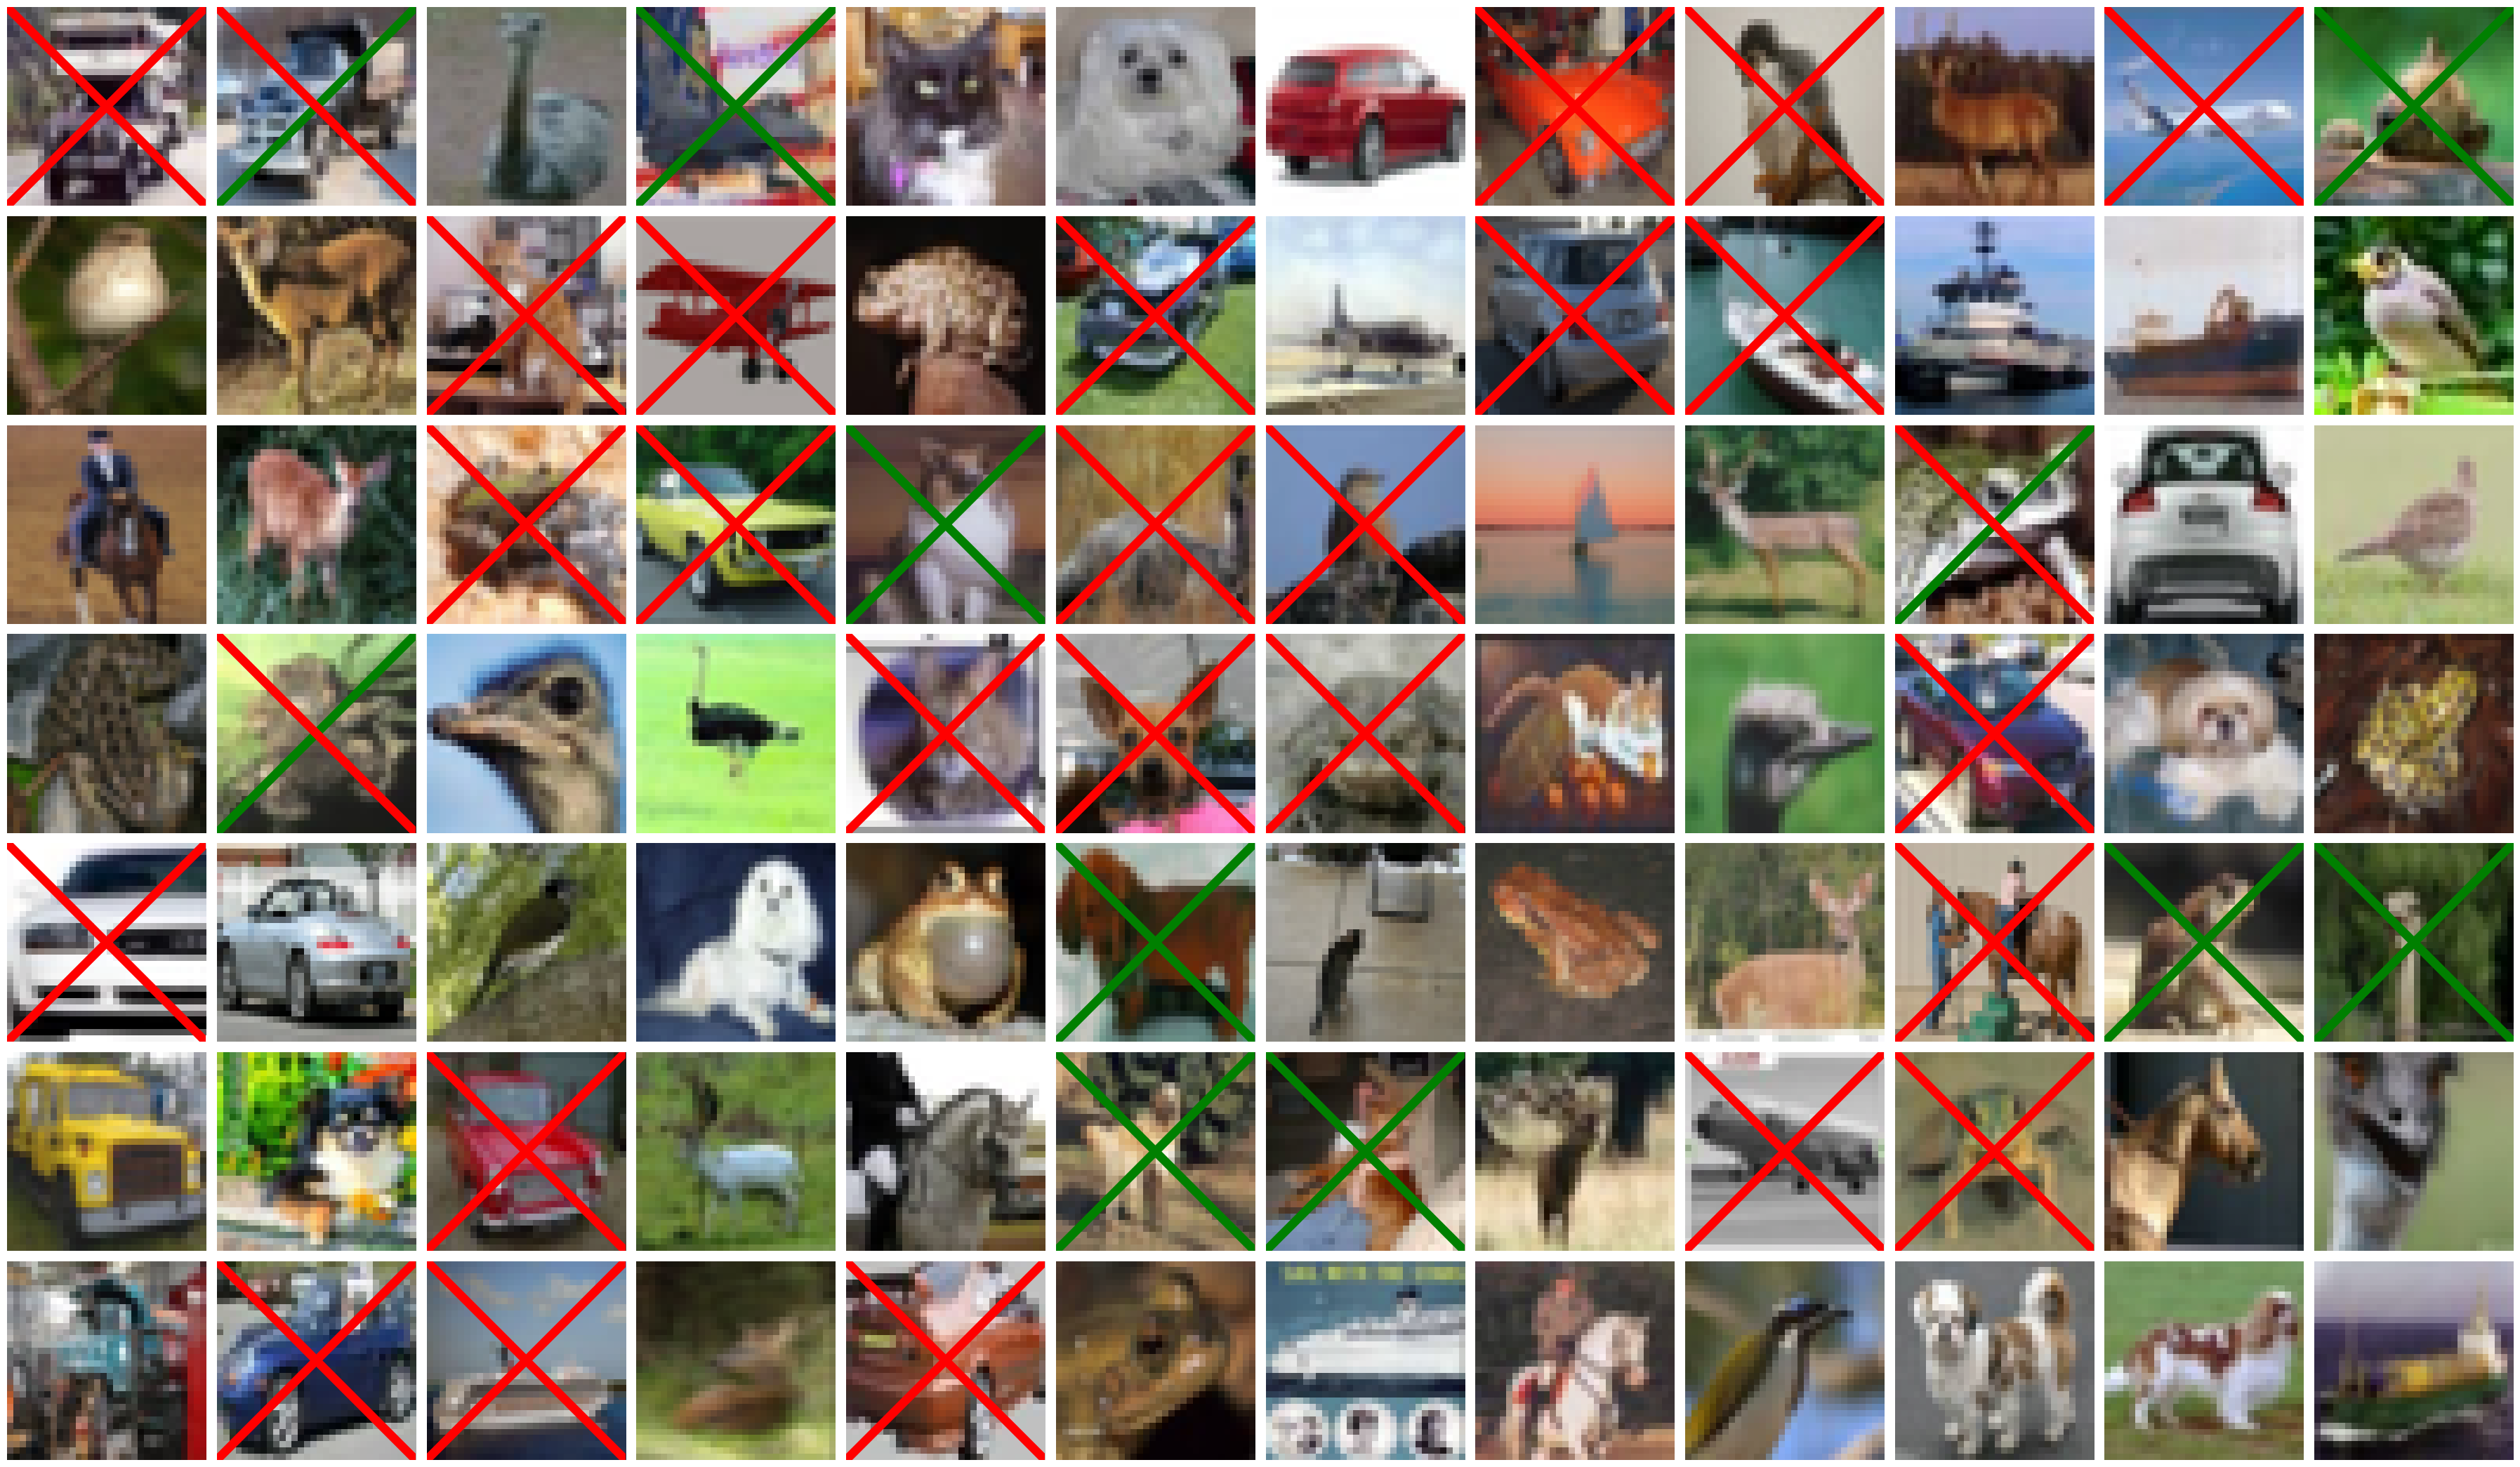

Model 1 Accuracy: 86.90%
Model 2 Accuracy: 66.67%


In [69]:
targetset = data.Subset(testset, indices)
imgs = [img for img, _, _ in targetset]

show_images_with_labels(imgs[:84], m1_outputs, m2_outputs, False)

### Load Benchmark Result

In [31]:
def load_outputs(output_path, dataset):
    with open(output_path, "r") as f:
        outputs = json.load(f)

    indices = outputs["Indicies"]
    random_subset = Subset(dataset, indices)

    m1_labels = []
    m2_labels = []
    imgs = []
    for img, label, _ in random_subset:
        imgs.append(img)
        if label in [2,3,4,5,6,7]:
            m2_labels.append(True)
        else:
            m2_labels.append(False)

        m1_labels.append(label)

    return (outputs['NN_model'], m1_labels), (outputs['SVC_model'], m2_labels), indices, imgs

In [32]:
m1_outputs, m2_outputs, indices, imgs = load_outputs('./crypto_hackathon/rand_sample_pred.json', testset)

## On-chain Verifier

### Make 32 * 32 to be 8 * 8

In [33]:
import torch.nn.functional as F

def compress_image(image, size):
    # Assume image is a PyTorch tensor with shape [C, H, W]
    
    # Add batch dimension [B, C, H, W] - B is batch size which is 1 in this case
    image = image.unsqueeze(0)
    
    # Calculate the kernel size, stride and padding needed for average pooling
    kernel_size = (image.size(2) // size, image.size(3) // size)
    stride = kernel_size
    padding = 0
    
    # Apply average pooling
    compressed_image = F.avg_pool2d(image, kernel_size=kernel_size, stride=stride, padding=padding)
    
    # Remove batch dimension and return the compressed image
    return compressed_image.squeeze(0)

def compress_process_dataset(dataset, size, label_map = [2,3,4,5,6,7]):
    x = []
    y = []

    for img, label, _ in dataset:
        img = compress_image(img, size)

        # Convert image to grayscale
        img_grayscale = rgb_to_gray(img)

        # Normalize grayscale image
        norm = np.linalg.norm(img_grayscale, ord=2)
        img_normalized = img_grayscale / norm

        x.append(img_normalized.flatten())
        y.append(label in label_map)

    return x,y

In [34]:
sample_set = Subset(testset, indices)
size = 8
x_test_compress, y_test_compress = compress_process_dataset(sample_set,size)
x_train_compress, y_train_compress = compress_process_dataset(trainset, size)

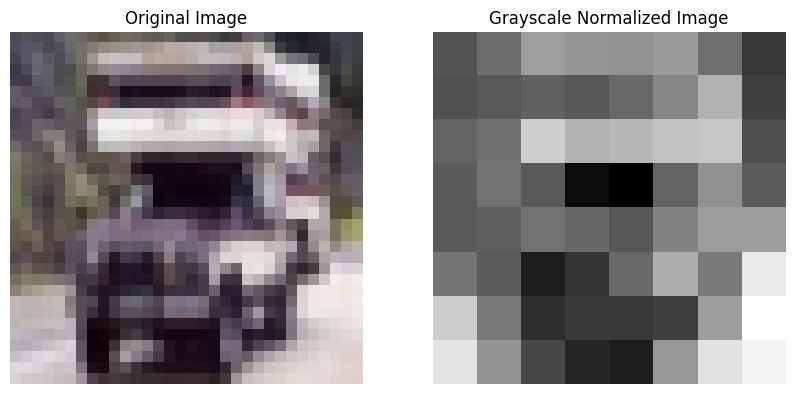

In [35]:
compare_imgages(imgs[0], x_test_compress[0], size, inv_normalize)

### Retrain SVC model

In [38]:
start_time = time.time()

#model_SVC = SVC(kernel = 'linear', max_iter=100, probability=True)
SVC_model_comp = LinearSVC(loss='hinge', max_iter=30000)
#fit
SVC_model_comp.fit(x_train_compress, y_train_compress)

print("Elapsed[s] : ", time.time() - start_time)
print("Train :", SVC_model_comp.score(x_train_compress, y_train_compress))
print("Test :", SVC_model_comp.score(x_test_compress, y_test_compress))

Elapsed[s] :  0.653191089630127
Train : 0.71262
Test : 0.68


In [86]:
m2_predictions = []
m2_labels = []

for index in tqdm(range(len(x_test_compress)), desc = 'SVC_model Batch Proof Gen'):
    pred = gen_witness_SVC(SVC_model_comp, x_test_compress[index])
    # pred == label
    m2_predictions.append(pred)
    m2_labels.append(y_test_compress[index])

SVC_model Batch Proof Gen: 100%|██████████| 100/100 [18:50<00:00, 11.30s/it]


In [39]:
show_images_with_labels(imgs, m1_outputs, (m2_predictions, m2_labels), False)

NameError: name 'show_images_with_labels' is not defined

In [41]:
folder = "./tmp"
def gen_SVC_verifier(model, grayscale_img, version, agg=False):
    model_path = os.path.join(folder, 'network.onnx')
    compiled_model_path = os.path.join(folder, 'network.compiled')
    settings_path = os.path.join(folder, 'settings.json') 
    witness_path = os.path.join(folder, 'witness.json')
    data_path = os.path.join(folder, 'input.json')
    srs_path = os.path.join(folder, 'kzg.srs')

    pk_path = os.path.join(folder, 'test.pk')
    vk_path = os.path.join(folder, 'test.vk')
    proof_path = os.path.join(folder, 'proof.json')

    grayscale_img = grayscale_img.reshape(1,-1)
    model = sk2torch.wrap(model)
    x = torch.from_numpy(grayscale_img)
    torch_out = model.predict(x)

    torch.onnx.export(model,               # model being run
                    # model input (or a tuple for multiple inputs)
                    x,
                    # where to save the model (can be a file or file-like object)
                    model_path,
                    export_params=True,        # store the trained parameter weights inside the model file
                    opset_version=10,          # the ONNX version to export the model to
                    do_constant_folding=True,  # whether to execute constant folding for optimization
                    input_names=['input'],   # the model's input names
                    output_names=['output'],  # the model's output names
                    dynamic_axes={'input': {0: 'batch_size'},    # variable length axes
                                    'output': {0: 'batch_size'}})

    d = ((x).detach().numpy()).reshape([-1]).tolist()

    data = dict(input_shapes=[grayscale_img.shape[1:]],
                input_data=[d],
                output_data=[o.reshape([-1]).tolist() for o in torch_out])

    # Serialize data into file:
    json.dump(data, open(data_path, 'w'))

    !RUST_LOG=trace
    # TODO: Dictionary outputs
    res = ezkl.gen_settings(model_path, settings_path)
    assert res == True

    res = async_function(data_path, model_path, settings_path, "resource")

    res = ezkl.compile_circuit(model_path, compiled_model_path, settings_path)
    assert res == True

    # srs path
    res = ezkl.get_srs(srs_path, settings_path)

    # now generate the witness file
    res = ezkl.gen_witness(data_path, compiled_model_path, witness_path)
    assert os.path.isfile(witness_path)

    res = ezkl.setup(
        compiled_model_path,
        vk_path,
        pk_path,
        srs_path,
    )

    assert res == True
    assert os.path.isfile(vk_path)
    assert os.path.isfile(pk_path)
    assert os.path.isfile(settings_path)

    # GENERATE A PROOF
    res = ezkl.prove(
            witness_path,
            compiled_model_path,
            pk_path,
            proof_path,
            srs_path,
            "for-aggr", # for aggregated EVM proof only ELSE 'evm'
        )
    print ('Successfully generate ZK Proof!')
    print(res)
    assert os.path.isfile(proof_path)

    # verify our proof
    res = ezkl.verify(
            proof_path,
            settings_path,
            vk_path,
            srs_path,
        )

    assert res == True
    print("verified")

    aggregate_proof_path = os.path.join(folder, 'aggr.pf')
    aggregate_vk_path = os.path.join(folder, 'aggr.vk')
    aggregate_pk_path = os.path.join(folder, 'aggr.pk')

    # Generate a larger SRS. This is needed for the aggregated proof

    large_srs_path = os.path.join(folder, "large_kzg.srs")
    res = ezkl.get_srs(large_srs_path, settings_path=None, logrows=21)

    # Run mock aggregate to check whether the proof works
    # Use mock to check for validity as it takes a shorter time to check compared to a full aggregated proof

    res = ezkl.mock_aggregate([proof_path], 21)
    assert res == True


    # Setup the vk and pk for aggregate
    res = ezkl.setup_aggregate(
        [proof_path],
        aggregate_vk_path,
        aggregate_pk_path,
        large_srs_path,
        21
    )

    assert os.path.isfile(aggregate_vk_path)
    assert os.path.isfile(aggregate_pk_path)

    # Run aggregate proof
    res = ezkl.aggregate(
        aggregate_proof_path,
        [proof_path],
        aggregate_pk_path,
        large_srs_path,
        "evm",
        21,
        "safe"
    )

    assert os.path.isfile(aggregate_proof_path)

    # Check if the proof is valid
    res = ezkl.verify_aggr(
        aggregate_proof_path,
        aggregate_vk_path,
        large_srs_path,
        21,
    )
    assert res == True

    sol_code_path = os.path.join(folder, 'Verifier' + '_' + version + '.sol')
    abi_path = os.path.join(folder, 'Verifier.abi')

    # res = ezkl.create_evm_verifier(
    #     vk_path,
    #     srs_path,
    #     settings_path,
    #     sol_code_path,
    #     abi_path
    # )
    res = ezkl.create_evm_verifier_aggr(
        aggregate_vk_path,
        large_srs_path,
        sol_code_path,
        abi_path,
        [settings_path]
    )

    assert res == True
    assert os.path.isfile(sol_code_path)




    # with open(witness_path, "r") as f:
    #     wit = json.load(f)

    # with open(settings_path, "r") as f:
    #     setting = json.load(f)

    # prediction_array = []
    # for value in wit["outputs"]:
    #     for field_element in value:
    #         prediction_array.append(ezkl.vecu64_to_float(field_element, setting['model_output_scales'][0]))
    # return prediction_array[0]

In [ ]:
gen_SVC_verifier(SVC_model_comp, x_test_compress[0])

In [43]:
gen_SVC_verifier(SVC_model, x_test[0], "32*32")

## Baby Verifiers

In [2]:
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import tqdm

In [3]:
iris = load_iris()
dataset_iris = pd.DataFrame(
    data= np.c_[iris['data'], iris['target']],
    columns= iris['feature_names'] + ['target'])
dataset_iris

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2.0
146,6.3,2.5,5.0,1.9,2.0
147,6.5,3.0,5.2,2.0,2.0
148,6.2,3.4,5.4,2.3,2.0


In [4]:
class Model_iris(nn.Module):
    # define nn
    def __init__(self):
        super(Model_iris, self).__init__()
        self.fc1 = nn.Linear(4, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)

        return x

# Initialize Model
model_iris = Model_iris()

In [5]:
def train_iris(model):
    train_X, test_X, train_y, test_y = train_test_split(
        dataset_iris[dataset_iris.columns[0:4]].values, # use columns 0-4 as X
        dataset_iris.target, # use target as y
        test_size=0.2 # use 20% of data for testing
    )

    # Uncomment for sanity checks
    # print("train_X: ", train_X)
    # print("test_X: ", test_X)
    print("train_y: ", train_y)
    print("test_y: ", test_y)

    # our loss function
    loss_fn = nn.CrossEntropyLoss()

    # our optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)


    # use 800 EPOCHS
    EPOCHS = 800

    # Convert training data to pytorch variables
    train_X = Variable(torch.Tensor(train_X).float())
    test_X = Variable(torch.Tensor(test_X).float())
    train_y = Variable(torch.Tensor(train_y.values).long())
    test_y = Variable(torch.Tensor(test_y.values).long())


    loss_list     = np.zeros((EPOCHS,))
    accuracy_list = np.zeros((EPOCHS,))


    # we use tqdm for nice loading bars
    for epoch in tqdm.trange(EPOCHS):

        # To train, we get a prediction from the current network
        predicted_y = model(train_X)

        # Compute the loss to see how bad or good we are doing
        loss = loss_fn(predicted_y, train_y)

        # Append the loss to keep track of our performance
        loss_list[epoch] = loss.item()

        # Afterwards, we will need to zero the gradients to reset
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate the accuracy, call torch.no_grad() to prevent updating gradients
        # while calculating accuracy
        with torch.no_grad():
            y_pred = model(test_X)
            correct = (torch.argmax(y_pred, dim=1) == test_y).type(torch.FloatTensor)
            accuracy_list[epoch] = correct.mean()

    return test_X, test_y

In [8]:
iris_x, iris_y = train_iris(model_iris)

train_y:  114    2.0
78     1.0
93     1.0
68     1.0
120    2.0
      ... 
123    2.0
133    2.0
48     0.0
82     1.0
21     0.0
Name: target, Length: 120, dtype: float64
test_y:  22     0.0
53     1.0
19     0.0
111    2.0
145    2.0
2      0.0
18     0.0
55     1.0
136    2.0
45     0.0
81     1.0
108    2.0
127    2.0
10     0.0
85     1.0
41     0.0
44     0.0
92     1.0
73     1.0
12     0.0
72     1.0
88     1.0
117    2.0
71     1.0
139    2.0
13     0.0
130    2.0
33     0.0
115    2.0
132    2.0
Name: target, dtype: float64


100%|██████████| 800/800 [00:00<00:00, 2420.63it/s]


In [33]:
folder = "./tmp"
def gen_iris_setting(model, test_X, index):
    model_path = os.path.join(folder, 'network.onnx')
    settings_path = os.path.join(folder, 'settings.json') 
    data_path = os.path.join(folder, 'input.json')
    cal_data_path = os.path.join(folder, 'cal_data.json')

    # create a random input
    x = test_X[index].reshape(1, 4)

    # Flips the neural net into inference mode
    model.eval()

    # Export the model
    torch.onnx.export(model,                     # model being run
                    x,                         # model input (or a tuple for multiple inputs)
                    model_path,                # where to save the model (can be a file or file-like object)
                    export_params=True,        # store the trained parameter weights inside the model file
                    opset_version=10,          # the ONNX version to export the model to
                    do_constant_folding=True,  # whether to execute constant folding for optimization
                    input_names = ['input'],   # the model's input names
                    output_names = ['output'], # the model's output names
                    dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                    'output' : {0 : 'batch_size'}})

    data_array = ((x).detach().numpy()).reshape([-1]).tolist()

    data = dict(input_data = [data_array])

        # Serialize data into file:
    json.dump(data, open(data_path, 'w'))


    # use the test set to calibrate the circuit
    cal_data = dict(input_data = test_X.flatten().tolist())

    # Serialize calibration data into file:
    json.dump(data, open(cal_data_path, 'w'))

    !RUST_LOG=trace
    # TODO: Dictionary outputs
    res = ezkl.gen_settings(model_path, settings_path)
    assert res == True

def gen_iris_verifier(prefix):
    model_path = os.path.join(folder, 'network.onnx')
    compiled_model_path = os.path.join(folder, 'network.compiled')
    settings_path = os.path.join(folder, 'settings.json') 
    witness_path = os.path.join(folder, 'witness.json')
    data_path = os.path.join(folder, 'input.json')
    srs_path = os.path.join(folder, 'kzg.srs')

    pk_path = os.path.join(folder, 'test.pk')
    vk_path = os.path.join(folder, 'test.vk')
    proof_path = os.path.join(folder, 'proof.json')

    res = ezkl.compile_circuit(model_path, compiled_model_path, settings_path)
    assert res == True

    res = ezkl.get_srs(srs_path, settings_path)

    res = ezkl.setup(
            compiled_model_path,
            vk_path,
            pk_path,
            srs_path,
        )


    assert res == True
    assert os.path.isfile(vk_path)
    assert os.path.isfile(pk_path)
    assert os.path.isfile(settings_path)

    # Generate the Witness for the proof


    res = ezkl.gen_witness(data_path, compiled_model_path, witness_path)
    assert os.path.isfile(witness_path)
        

    # Generate the proof
    proof = ezkl.prove(
            witness_path,
            compiled_model_path,
            pk_path,
            proof_path,
            srs_path,
            "single",
        )

    print(proof)
    assert os.path.isfile(proof_path)

    # verify our proof

    res = ezkl.verify(
            proof_path,
            settings_path,
            vk_path,
            srs_path,
        )

    assert res == True
    print("verified")

    sol_code_path = os.path.join(prefix + '_verifier.sol')
    abi_path = os.path.join(folder, 'Verifier.abi')

    res = ezkl.create_evm_verifier(
            vk_path,
            srs_path,
            settings_path,
            sol_code_path,
            abi_path
        )

    assert res == True
    assert os.path.isfile(sol_code_path)




In [35]:
model_path = os.path.join(folder, 'network.onnx')
settings_path = os.path.join(folder, 'settings.json') 
cal_data_path = os.path.join(folder, 'cal_data.json')

gen_iris_setting(model_iris, iris_x, 1)
res = await ezkl.calibrate_settings(cal_data_path, model_path, settings_path, "resources")  # Optimize for resources
gen_iris_verifier("1")

spawning module 2
spawning module 2
spawning module 2


{'instances': [[[0, 0, 0, 0], [12436184717236109307, 3962172157175319849, 7381016538464732718, 1011752739694698287], [7959790035488735211, 12951774245394433045, 16242874202584236123, 560012691975822483]]], 'proof': '1554e3fa15262e927061c0ce3758e030b4249986f4d0556213568e8f32e3cf640ae296502d32d76337dd13ed6bbd7ae9da0f1c6b063078049ad2fb3390bd06942a59984547169f3b088f3be937d302995f3acb289e378971ef87f0860a62a5f61a2c7265c798afbadae813f61dcc2835887ac84a823708c6f8510a1202a0c63f26a0e6dff335abb2a0f4680b6dfa1dd504f199dc9ae708f3ed22d75dbbdfbd6a0c657718950e1022bc1033402046fa4b8fe80947b5ed43dca6486b0bdddb288710eb493498dbdf44c45e8baeda7384de761517b8085366862781087e9265dfba2a0a6f0b753e1a01cd917b4981fc34537741815fef39975820332a36feabf67e1128257f987743f4702b0c529fddb2a2ed46f0b3ad6ba7599fd52ba263c4352f2033268474778d94ba70cb3993b9b716d00971d531c733526f2dac2e14c46e112d2471390fd708522dbf4e64ddacc7569038e904b684055cb11b410d603c53cf1369498a3116f4f3153871623514a2cd165b9a1cb0d98cb65b4e260f735a6f9c0009f66d2bb7b0b5

spawning module 2
spawning module 2


spawning module 2


{'instances': [[[4439626704750641036, 14446068936887303725, 8908235843737744841, 1336570672465538328], [7959790035488735211, 12951774245394433045, 16242874202584236123, 560012691975822483], [0, 0, 0, 0]]], 'proof': '15729502532502541cfd157dfecdc5d22a7c603dcacc203bf3cebc27093b0b5a299a8225945ceb2b63c6afd204a78d0b793531a6d8db2c043c6067f615aba29b06a80c173b3c482497c0625d22740e8bacbefe555701280d1fc06aeb2903516f1a8452f5ba23b0100d60a1cf0608c74f4f380808ef2b6c1a38c2e34ec4fd442512bc4637d78eefc48bd25a45c4c845cba099e58d73fb69030dac14d2df6edfe81e740b31d91a9eb04a1eb28ae4af8391966fca7833e5750d3738f6924222e3d1072ca8d6970bdfc9824e03d54d76eb20220748cbeaa4643868d864082f8be3bf0ef179bba2a44f2a531b3e70aa09ef06fc8accfb9167693dbf51a059099f05b20281013cb9dddda6e0fd54db2ca037b0bbdcf5e38a5dc6895906ffd4d151d99a1b91e192aa84e6ed2b56eb292a3cb1a54a9102cf7987968b5bc906247a4b16f10f7230bf90a21f3c1835410fd8568997770c8159f5d9d433760f280e4c6d65f2221ecb7858c53989abbbb047f77908cfe82afe94f937aaaf8ebf600fa4b64e0a26c34e804dc20f87